In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,array_to_img
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/soumikrakshit/anime-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rajveers222
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/anime-faces


100%|██████████| 441M/441M [00:03<00:00, 140MB/s]


In [5]:
import os

folder_path = "/content/anime-faces/data/data"
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

# Filter only valid image files
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]

print(f"Total images: {len(image_files)}")
print("Sample images:", image_files[:10])


Total images: 21551
Sample images: ['526.png', '7621.png', '5097.png', '10346.png', '4547.png', '742.png', '10203.png', '21238.png', '15170.png', '236.png']


**Visulaize the dataset**

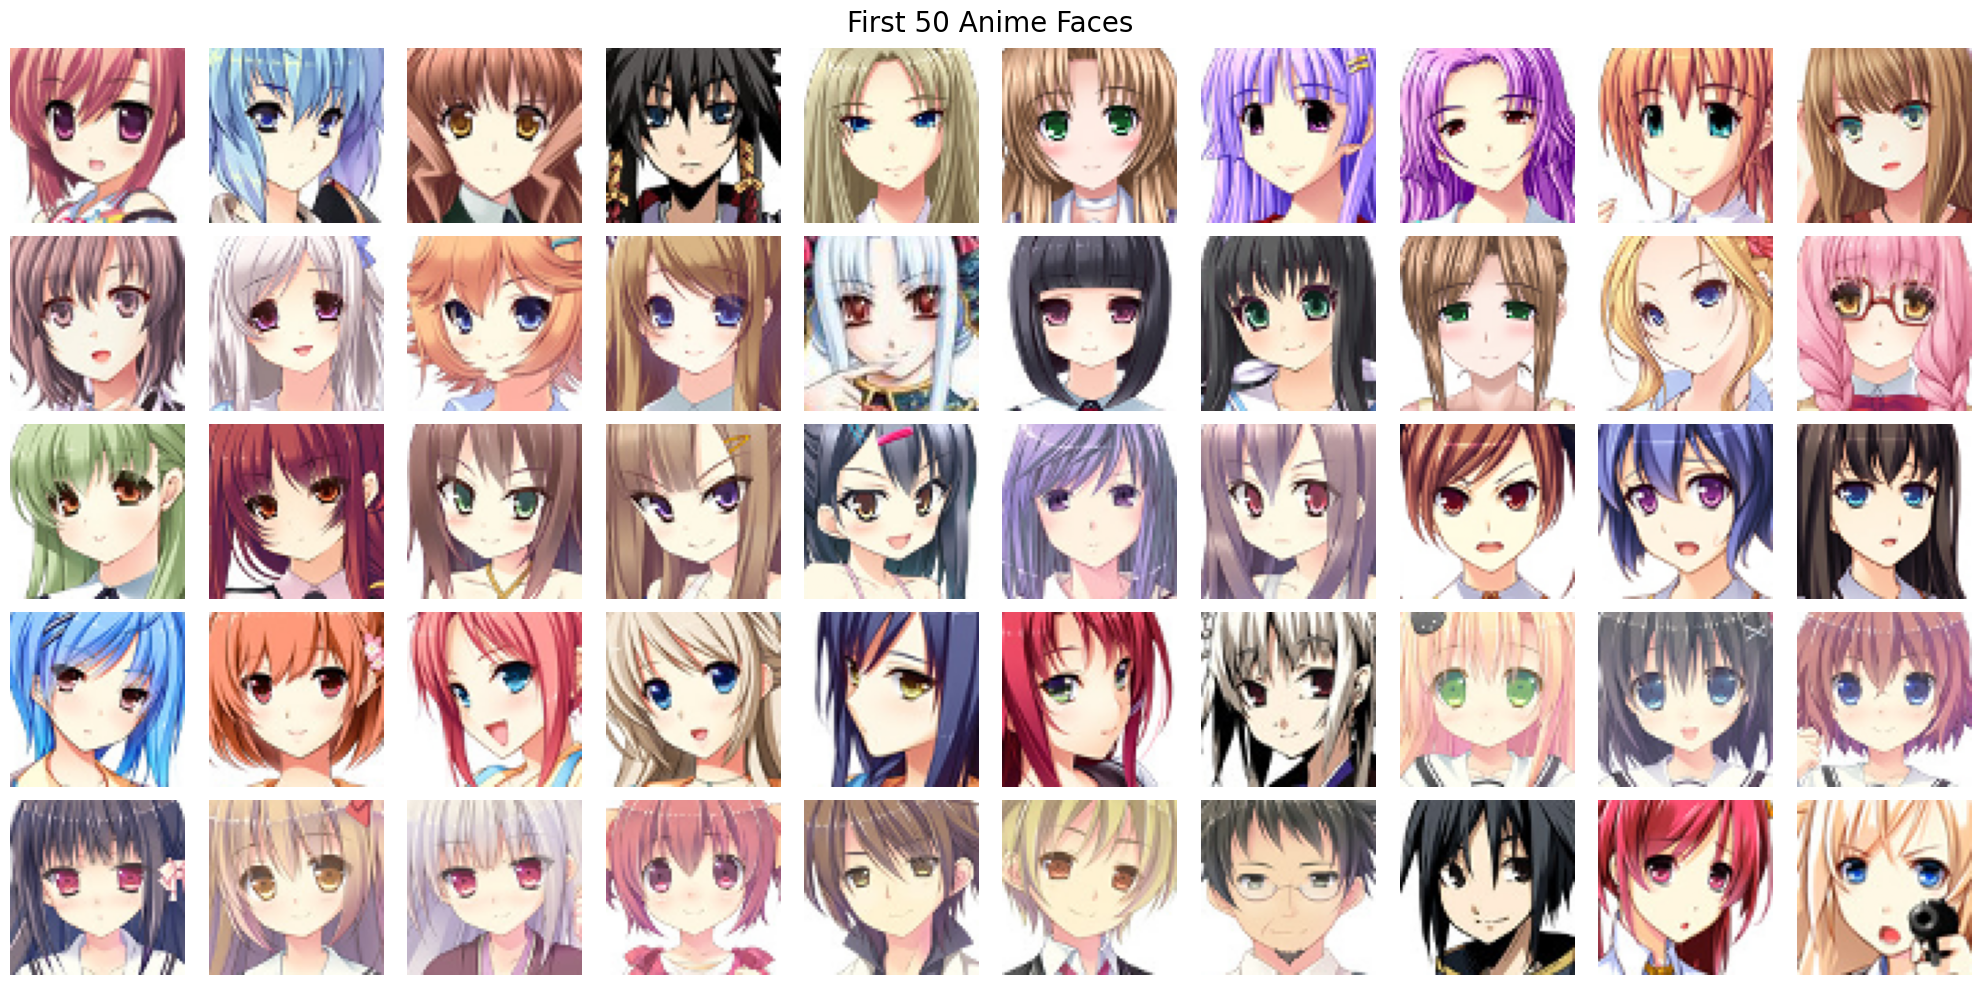

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Folder path
folder_path = "/content/anime-faces/data/data"
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

# Filter and sort image files (first 50 valid ones)
image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)])[:50]

# Plot settings
plt.figure(figsize=(20, 10))  # 5 rows × 10 columns = 50

for i, img_name in enumerate(image_files):
    img_path = os.path.join(folder_path, img_name)
    try:
        img = mpimg.imread(img_path)
        plt.subplot(5, 10, i + 1)
        plt.imshow(img)
        plt.axis("off")
    except Exception as e:
        print(f"Error loading {img_name}: {e}")

plt.suptitle("First 50 Anime Faces", fontsize=20)
plt.tight_layout()
plt.show()


**Preprocess Images**

In [7]:
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define folder path
folder_path = "/content/anime-faces/data/data"
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

# Get and filter image filenames
image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)])

# Create list of full image paths
image_paths = [os.path.join(folder_path, img_name) for img_name in image_files]

# Set target image size (common for anime GANs: 64x64 or 128x128)
img_size = (64, 64)

# Load all images, resize, normalize to [-1, 1]
train_images = []
for path in tqdm(image_paths, desc="Loading and processing images"):
    try:
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = (img_array / 127.5) - 1.0  # Normalize to [-1, 1]
        train_images.append(img_array)
    except Exception as e:
        print(f"Skipping {path}: {e}")

# Convert to final NumPy array
train_images = np.array(train_images, dtype=np.float32)

# Check shape
print("Shape of train_images:", train_images.shape)


Loading and processing images: 100%|██████████| 21551/21551 [00:07<00:00, 2916.35it/s]


Shape of train_images: (21551, 64, 64, 3)


In [8]:
train_images.shape

(21551, 64, 64, 3)

In [9]:
train_images[0]

array([[[ 0.94509804,  0.427451  ,  0.24705887],
        [ 0.96862745,  0.4431373 ,  0.33333337],
        [ 0.9529412 ,  0.5058824 ,  0.35686278],
        ...,
        [ 0.3803922 , -0.38039213, -0.19215685],
        [ 0.43529415, -0.34117645, -0.15294117],
        [ 0.4901961 , -0.17647058, -0.02745098]],

       [[ 0.90588236,  0.43529415,  0.2313726 ],
        [ 0.92941177,  0.43529415,  0.32549024],
        [ 0.9529412 ,  0.4431373 ,  0.35686278],
        ...,
        [ 0.33333337, -0.36470586, -0.19215685],
        [ 0.39607847, -0.372549  , -0.16862744],
        [ 0.35686278, -0.36470586, -0.19215685]],

       [[ 0.8980392 ,  0.41176474,  0.26274514],
        [ 0.96862745,  0.47450984,  0.33333337],
        [ 0.75686276,  0.14509809,  0.16078436],
        ...,
        [ 0.4039216 , -0.31764704, -0.12156862],
        [ 0.3803922 , -0.372549  , -0.1607843 ],
        [ 0.35686278, -0.40392154, -0.20784312]],

       ...,

       [[ 1.        ,  1.        ,  1.        ],
        [ 1

**Create generator and discriminator**

In [10]:
from tensorflow.keras import initializers

# Latent vector dimension (size of random noise input to Generator)
LATENT_DIM = 100

# Weight initializer as per DCGAN paper: N(0, 0.02)
WEIGHT_INIT = initializers.RandomNormal(mean=0.0, stddev=0.02)

# Number of channels (3 for RGB anime images)
CHANNELS = 3



**Generator Model**

In [11]:
from tensorflow.keras import layers, models

def build_generator(latent_dim, channels=3):
    model = models.Sequential(name="Generator")

    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,),
                           kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))  # Now 8x8x256

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same',
                                     use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  # Now 16x16x128

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same',
                                     use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  # Now 32x32x64

    model.add(layers.Conv2DTranspose(channels, kernel_size=4, strides=2, padding='same',
                                     use_bias=False, activation='tanh',
                                     kernel_initializer=WEIGHT_INIT))  # Final 64x64x3

    return model


**Discriminator model**

In [12]:
def build_discriminator(input_shape=(64, 64, 3)):
    model = models.Sequential(name="Discriminator")

    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same',
                            input_shape=input_shape, kernel_initializer=WEIGHT_INIT))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same',
                            kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same',
                            kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=WEIGHT_INIT))

    return model


**Create DCGAN**

In [13]:
import tensorflow as tf

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Generate random noise
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([real_images, generated_images], axis=0)

        # Assign labels: 1s for real, 0s for fake
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add noise to labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train Generator
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(fake_images)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Track losses
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_images=16, latent_dim=100, save_path="generated_images"):
        self.num_images = num_images
        self.latent_dim = latent_dim
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)

        # Fixed seed for consistent output
        self.seed = tf.random.normal([num_images, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5  # Rescale to [0,255]
        generated_images = tf.cast(generated_images, tf.uint8)

        # Plot
        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_images):
            plt.subplot(4, 4, i + 1)
            img = generated_images[i].numpy()
            plt.imshow(img)
            plt.axis("off")

        plt.tight_layout()
        save_name = os.path.join(self.save_path, f"epoch_{epoch+1:03d}.png")
        plt.savefig(save_name)
        plt.close()


In [15]:
generator = build_generator(LATENT_DIM, channels=CHANNELS)
discriminator = build_discriminator(input_shape=(64, 64, CHANNELS))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)


In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Optimizers (LR = 0.0002, beta_1 = 0.5 as per DCGAN paper)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

loss_fn = BinaryCrossentropy()

dcgan.compile(g_optimizer=g_optimizer, d_optimizer=d_optimizer, loss_fn=loss_fn)


In [18]:
monitor_callback = DCGANMonitor(num_images=16, latent_dim=LATENT_DIM, save_path="generated_faces")


In [19]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [20]:
EPOCHS = 100  # You can increase this if needed

dcgan.fit(dataset, epochs=EPOCHS, callbacks=[monitor_callback])


Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - d_loss: 2.5619 - g_loss: 3.8768
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - d_loss: 1.8583 - g_loss: 5.3965
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - d_loss: 0.5816 - g_loss: 2.2390
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - d_loss: 0.6683 - g_loss: 2.0751
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - d_loss: 0.4473 - g_loss: 1.9678
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - d_loss: 0.4484 - g_loss: 2.1359
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - d_loss: 0.3667 - g_loss: 1.5664
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - d_loss: 0.3510 - g_loss: 1.5636
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - d_loss: 0.4067 - g_loss: 1.5579
Epoch 10/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - d_loss: 0.4385 - g_loss: 1.4845
Epoch 11/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - d_loss: 0.5152 - g_loss: 1.2508
Epoch 12/100
169/1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


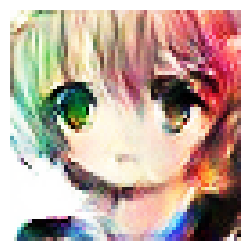

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Number of images to generate
num_images = 1

# Sample random noise vectors
random_latent_vectors = np.random.normal(size=(num_images, LATENT_DIM))

# Generate fake images
generated_images = generator.predict(random_latent_vectors)

# Rescale pixel values from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

# Plot generated images
plt.figure(figsize=(3, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()


In [32]:
from zipfile import ZipFile
import shutil

# Zip the folder
shutil.make_archive('generated_faces', 'zip', 'generated_faces')

# Now download using google.colab files module
from google.colab import files
files.download('generated_faces.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>